In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gmean
import matplotlib.pyplot as plt
import sqlite3

In [2]:
from utils.etimodel import ETIModel

## Data Preparation

In [3]:
_4dm4_connection = sqlite3.connect("dataset/4dm4.db")

_4dm4_scores_query = """SELECT scores.player_name, player_data.player_id, scores.round, 
scores.beatmap_type, scores.beatmap_tag, scores.score, scores.score_logit 
FROM scores LEFT JOIN player_data ON scores.player_name = player_data.player_name 
WHERE beatmap_type != \"SV\""""

_4dm4_data = pd.read_sql(_4dm4_scores_query, _4dm4_connection)

In [4]:
_4dm4_data

,player_name,player_id,round,beatmap_type,beatmap_tag,score,score_logit
0,drag_,17959501,Q,RC,1,980590,3.922366
1,JPBenedictGame,12304092,Q,RC,1,991778,4.792686
2,iVALORUS,12096188,Q,RC,1,950399,2.952871
3,BL5,13187997,Q,RC,1,994054,5.119073
4,-Tebo-,12092659,Q,RC,1,994631,5.221730
...,...,...,...,...,...,...,...
2760,MisteurFR,14055233,GF,TB,1,932066,2.618867
2761,Gray Hardrock,9049282,GF,TB,1,908730,2.298226
2762,--Pavin--,12046267,GF,TB,1,919303,2.432914
2763,shokoha,14134289,GF,TB,1,910134,2.315272


In [5]:
from utils.tables import get_table_from_records

In [6]:
_4dm4_data['beatmap'] = _4dm4_data['round'] + "_" + _4dm4_data['beatmap_type'] + "_" + _4dm4_data['beatmap_tag'].astype(str)

_4dm4_table = get_table_from_records(_4dm4_data, 'player_name', 'beatmap', 'score_logit')

In [7]:
_4dm4_table

beatmap,F_HB_1,F_HB_2,F_HB_3,F_LN_1,F_LN_2,F_LN_3,F_RC_1,F_RC_2,F_RC_3,F_RC_4,...,SF_LN_1,SF_LN_2,SF_LN_3,SF_RC_1,SF_RC_2,SF_RC_3,SF_RC_4,SF_RC_5,SF_RC_6,SF_TB_1
player_name,,,,,,,,,,,,,,,,,,,,,
--Pavin--,3.403862,4.130791,4.297121,NaN,NaN,3.972358,NaN,4.405308,4.181753,NaN,...,NaN,NaN,NaN,4.640350,NaN,NaN,4.738713,3.727061,3.925312,NaN
-Guille,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-Julio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-Pauze-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-SparklingCat-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
terror67890,NaN,NaN,NaN,3.500324,3.159003,2.650601,NaN,NaN,NaN,NaN,...,NaN,3.215677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
twitch chat,NaN,NaN,NaN,NaN,NaN,NaN,3.277534,NaN,NaN,NaN,...,NaN,NaN,NaN,3.417435,NaN,NaN,3.774716,NaN,NaN,NaN
u8_sunflower,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
def get_beatmap_category_table(records: pd.DataFrame, category: str):
    return get_table_from_records(records[records['beatmap_type'] == category], 'player_name', 'beatmap', 'score_logit')

In [9]:
rc = get_beatmap_category_table(_4dm4_data, "RC")
hb = get_beatmap_category_table(_4dm4_data, "HB")
ln = get_beatmap_category_table(_4dm4_data, "LN")

In [10]:
model = ETIModel(lambda x: np.nanquantile(x, 0.25, axis=1))

rc_eti = pd.DataFrame(model.fit(rc.values), index=rc.index)
hb_eti = pd.DataFrame(model.fit(hb.values), index=hb.index)
ln_eti = pd.DataFrame(model.fit(ln.values), index=ln.index)

In [11]:
# cats are cute thank you

eti_cats = pd.DataFrame(index=_4dm4_table.index)
eti_cats['rc'] = rc_eti
eti_cats['hb'] = hb_eti
eti_cats['ln'] = ln_eti

In [12]:
eti_cats['rc'] = eti_cats['rc'].fillna(eti_cats['rc'].quantile(0.25))
eti_cats['hb'] = eti_cats['hb'].fillna(eti_cats['hb'].quantile(0.25))
eti_cats['ln'] = eti_cats['ln'].fillna(eti_cats['ln'].quantile(0.25))

In [13]:
eti_cats['avg'] = gmean(eti_cats[['rc', 'hb', 'ln']].values, axis=1)

In [14]:
eti_cats.sort_values('avg', ascending=False).head(15)

,rc,hb,ln,avg
player_name,,,,
shokoha,1.493390e+06,2.141910e+08,1.073502e+06,7.002597e+06
Gray Hardrock,3.705708e+03,1.165229e+03,3.255265e+02,1.120185e+03
MisteurFR,1.700703e+06,3.493084e+02,8.485425e-01,7.958606e+02
--Pavin--,2.741771e+04,2.456862e+02,2.528916e+01,5.543476e+02
henryalexbr,7.144803e+04,5.139955e+01,3.526885e+00,2.348445e+02
Keskidi,2.956030e+02,1.262057e+02,1.807414e+02,1.889217e+02
Lazereed,1.752477e+01,3.263831e+02,1.038831e+03,1.811236e+02
Micleak,1.380132e+03,7.749710e+01,4.686982e+01,1.711459e+02
Ricizus,3.918360e+03,3.237497e+01,2.558067e+01,1.480500e+02


In [15]:
np.log(eti_cats).sort_values('avg', ascending=False).head(15)

,rc,hb,ln,avg
player_name,,,,
shokoha,14.216559,19.182379,13.886437,15.761792
Gray Hardrock,8.217630,7.060673,5.785444,7.021249
MisteurFR,14.346552,5.855955,-0.164235,6.679424
--Pavin--,10.218944,5.504055,3.230376,6.317792
henryalexbr,11.176726,3.939629,1.260415,5.458923
Keskidi,5.689017,4.837914,5.197067,5.241333
Lazereed,2.863616,5.788072,6.945851,5.199180
Micleak,7.229934,4.350240,3.847374,5.142516
Ricizus,8.273429,3.477386,3.241837,4.997550


In [16]:
eti_cats.describe()

,rc,hb,ln,avg
count,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02
mean,1.651693e+04,1.070969e+06,5.387910e+03,3.503211e+04
std,1.596782e+05,1.514559e+07,7.590669e+04,4.951571e+05
min,1.629876e-02,3.076832e-03,2.964194e-02,5.972230e-02
25%,2.388647e-01,3.551550e-01,2.717896e-01,2.824915e-01
50%,3.529023e-01,4.379413e-01,3.111390e-01,4.185454e-01
75%,1.269591e+00,1.050371e+00,9.350049e-01,1.143080e+00
max,1.700703e+06,2.141910e+08,1.073502e+06,7.002597e+06


In [17]:
np.log(eti_cats).describe()

,rc,hb,ln,avg
count,200.000000,200.000000,200.000000,200.000000
mean,-0.100230,-0.170808,-0.306141,-0.192393
std,2.701490,2.152591,2.112167,2.060985
min,-4.116666,-5.783855,-3.518565,-2.818050
25%,-1.431858,-1.035201,-1.302727,-1.264147
50%,-1.041588,-0.825671,-1.167516,-0.870971
75%,0.238695,0.048969,-0.067935,0.133675
max,14.346552,19.182379,13.886437,15.761792


In [18]:
np.corrcoef(np.log(eti_cats)[['rc', 'hb', 'ln']].T)

array([[1.        , 0.73522107, 0.52143156],
       [0.73522107, 1.        , 0.80658274],
       [0.52143156, 0.80658274, 1.        ]])

In [19]:
log_eti = np.log(eti_cats)

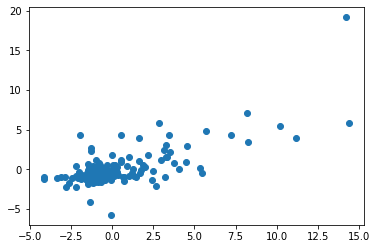

In [20]:
plt.scatter(log_eti['rc'], log_eti['hb'])

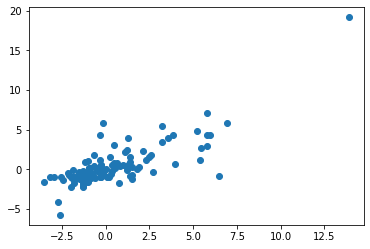

In [21]:
plt.scatter(log_eti['ln'], log_eti['hb'])

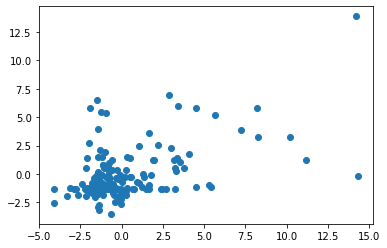

In [22]:
plt.scatter(log_eti['rc'], log_eti['ln'])

In [23]:
def regression_function(x, y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    b1 = np.sum((x - xbar) * (y - ybar)) / np.sum((x - xbar) ** 2)
    b0 = ybar - b1 * xbar
    print(b1, b0)
    return lambda x: b1 * x + b0

In [24]:
rc_hb = regression_function(log_eti['rc'].values, log_eti['hb'].values)
ln_hb = regression_function(log_eti['ln'].values, log_eti['hb'].values)

0.585836077624996 -0.1120897663344045
0.8220197058557505 0.08084563982433002


In [25]:
x_rc, y_rc = (-2.5, 15), (rc_hb(-2.5), rc_hb(15))
x_ln, y_ln = (-2.5, 12.5), (ln_hb(-2.5), ln_hb(12.5))

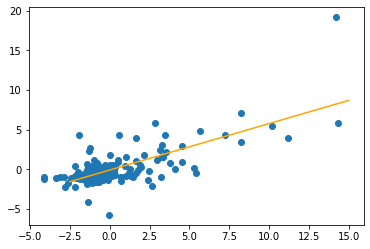

In [26]:
plt.scatter(log_eti['rc'], log_eti['hb'])
plt.plot(x_rc, y_rc, c='orange')
plt.show()

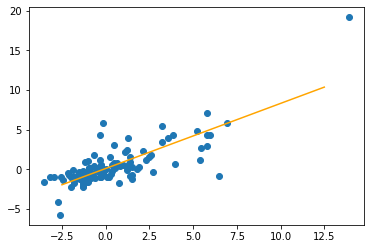

In [27]:
plt.scatter(log_eti['ln'], log_eti['hb'])
plt.plot(x_ln, y_ln, c='orange')
plt.show()

In [28]:
from scipy.stats import shapiro

def residual(y_true, y_pred):
    return y_true - y_pred

residual_rc = residual(log_eti['hb'].values, rc_hb(log_eti['rc'].values))
residual_ln = residual(log_eti['hb'].values, ln_hb(log_eti['ln'].values))

(array([  1.,   8.,  30., 138.,  16.,   5.,   1.,   0.,   0.,   1.]),
 array([-5.65284595, -3.99097185, -2.32909776, -0.66722366,  0.99465044,
         2.65652454,  4.31839864,  5.98027274,  7.64214684,  9.30402094,
        10.96589504]),
 <BarContainer object of 10 artists>)

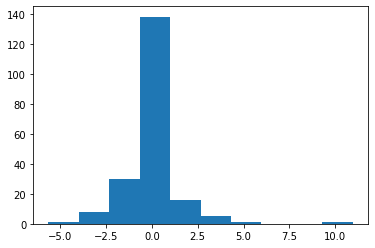

In [29]:
plt.hist(residual_rc)

(array([  1.,   1.,   7.,  24., 138.,  21.,   5.,   1.,   1.,   1.]),
 array([-6.23224234, -4.84035728, -3.44847222, -2.05658717, -0.66470211,
         0.72718295,  2.119068  ,  3.51095306,  4.90283811,  6.29472317,
         7.68660823]),
 <BarContainer object of 10 artists>)

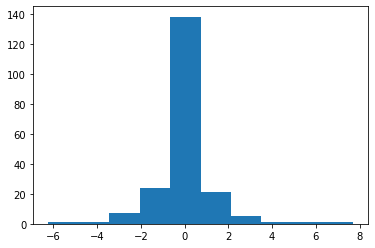

In [30]:
plt.hist(residual_ln)

In [31]:
shapiro(residual_rc)

ShapiroResult(statistic=0.7718916535377502, pvalue=2.4150052820698896e-16)

In [32]:
shapiro(residual_ln)

ShapiroResult(statistic=0.7978919148445129, pvalue=2.3025637759042494e-15)

(array([  2., 104.,  73.,  11.,   8.,   1.,   0.,   0.,   0.,   1.]),
 array([-5.78385487, -3.28723151, -0.79060816,  1.70601519,  4.20263855,
         6.6992619 ,  9.19588526, 11.69250861, 14.18913197, 16.68575532,
        19.18237868]),
 <BarContainer object of 10 artists>)

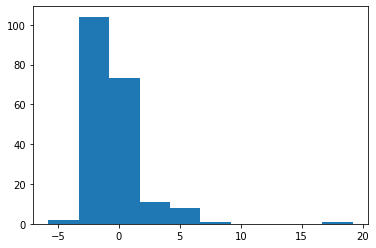

In [33]:
plt.hist(log_eti['hb'].values)

(array([  8., 122.,  36.,  16.,   8.,   3.,   3.,   1.,   1.,   2.]),
 array([-4.11666645, -2.27034459, -0.42402272,  1.42229915,  3.26862102,
         5.11494289,  6.96126476,  8.80758663, 10.6539085 , 12.50023037,
        14.34655224]),
 <BarContainer object of 10 artists>)

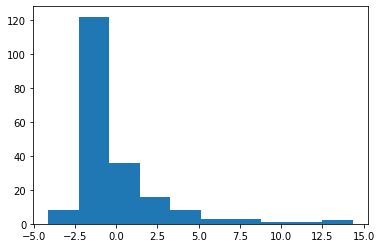

In [34]:
plt.hist(log_eti['rc'].values)

(array([ 18., 132.,  28.,   9.,   3.,   8.,   1.,   0.,   0.,   1.]),
 array([-3.51856503, -1.77806483, -0.03756464,  1.70293556,  3.44343576,
         5.18393595,  6.92443615,  8.66493635, 10.40543654, 12.14593674,
        13.88643694]),
 <BarContainer object of 10 artists>)

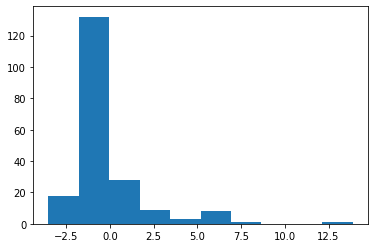

In [35]:
plt.hist(log_eti['ln'].values)